# 4.1 多层感知机

In [ ]:
pip install d2l==0.17.6

In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l

ReLU函数

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install --upgrade pip

In [ ]:
pip install matplotlib

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5,2.5))

In [ ]:
# relu导数的图像
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad for relu', figsize=(5,2.5))

sigmoid函数

In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5,2.5))

In [ ]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5,2.5))

tanh函数

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5,2.5))

In [ ]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5,2.5))

## 4.2 多层感知机的从零开始实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = torch.zeros(num_hiddens, requires_grad=True)
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2]

In [ ]:
# 激活函数
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(a, X)

In [ ]:
# 模型
def net(X):
  X = X.reshape(-1, num_inputs)
  H = relu(X@W1 + b1)
  return (H@W2 + b2)

In [ ]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction="none")

In [ ]:
# 训练
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [ ]:
d2l.predict_ch3(net, test_iter)

## 4.3 多层感知机的简洁实现

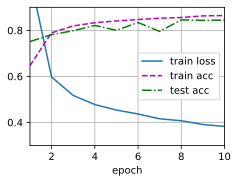

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weight(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight);

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


## 4.4 模型选择、欠拟合和过拟合

In [ ]:
# 多项式回归
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 生成数据集
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练数据集和测试数据集的大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=((n_train + n_test), 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
  poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# NumPydarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [ ]:
features[:2], poly_features[:2, :], labels[:2]

In [ ]:
# 对模型进行训练和测试
def evaluate_loss(net, data_iter, loss):
  '''评估给定数据集上模型的损失'''
  metric = d2l.Accumulator(2) # 损失的总和、样本数量
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
  loss = nn.MSELoss(reduction='none')
  input_shape = train_features.shape[-1]
  net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
  batch_size = min(10, train_labels.shape[0])
  train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
  test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
  trainer = torch.optim.SGD(net.parameters(), lr=0.01)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs+1], ylim=[1e-3, 1e2], legend=['train', 'test'], yscale='log')
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch+1)%20 == 0:
      animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))

  print('weight:', net[0].weight.data.numpy())

In [ ]:
# 三阶多项式函数拟合（正常）
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

In [ ]:
# 线性拟合函数（欠拟合）
# 从多项式特征中选择前两个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

In [ ]:
# 高阶多项式函数拟合
# 从多项式中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

## 4.6 暂退法

从0开始实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  # 在本情况下，所有元素都被丢弃
  if dropout == 1:
    return torch.zeros_like(X)
  # 在本情况下，所有元素都被保留
  if dropout == 0:
    return X
  mask = (torch.randn(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

In [ ]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

# 定义模型
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
    super(Net, self).__init__()
    self.num_inputs = num_inputs
    self.training = is_training
    self.lin1 = nn.Linear(num_inputs, num_hiddens1)
    self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
    self.lin3 = nn.Linear(num_hiddens2, num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
    # 只有在训练模型中才使用暂退法
    if self.training == True:
      # 在第一个全连接层之后加一个暂退层
      H1 = dropout_layer(H1, dropout1)
    H2 = self.relu(self.lin2(H1))
    if self.training == True:
      # 在第二个全连接层之后加一个暂退层
      H2 = dropout_layer(H2, dropout2)
    out = self.lin3(H2)
    return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

# 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

简洁实现

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # 在第一个全连接层之后加一个暂退层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # 在第二个全连接层之后加一个暂退层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weight(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight);

trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.10 实战Kaggle比赛：预测房价

In [16]:
# 下载和缓存数据集
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB =dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
  '''下载一个DATA_HUB中的文件，返回本地文件名'''
  assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdighest() == sha1_hash:
      return fname # 命中缓存
  print(f"正在从{url}下载{fname}...")
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

def download_extract(name, folder=None):
  '''下载并解压zip/tar文件'''
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, '只有zip/tar文件可以被解压缩'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
  '''下载DATA_HUB中的所有文件'''
  for name in DATA_HUB:
    download(name)

In [17]:
# 访问和读取数据集
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
                                  '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
                                 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)


In [19]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [20]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [22]:
# 数据预处理

# 若无法获得测试数据，可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [23]:
# ummy_na=True将na（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True) # one_hot encoding
all_features.shape

(2919, 331)

In [35]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)

In [36]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features, 1))
  return net

def log_rmse(net, features, labels):
  '''为了在取对数时进一步稳定该值，将小于1的设置为1'''
  clipped_preds = torch.clamp(net(features), 1, float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
  return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # 这里使用的是Adam优化器
  optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

In [42]:
# k折交叉验证
def get_k_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j*fold_size, (j+1)*fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
               xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
    print(f'折{i+1}，训练log rmse{float(train_ls[-1]):f}',f'验证log rmse{float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.128690 验证log rmse0.148969
折2，训练log rmse0.130461 验证log rmse0.116887
折3，训练log rmse0.130328 验证log rmse0.127164
折4，训练log rmse0.125845 验证log rmse0.160373
折5，训练log rmse0.124768 验证log rmse0.162658
折6，训练log rmse0.130400 验证log rmse0.121790
折7，训练log rmse0.130000 验证log rmse0.127455
折8，训练log rmse0.129795 验证log rmse0.139037
折9，训练log rmse0.123400 验证log rmse0.184013
折10，训练log rmse0.128919 验证log rmse0.136465
10-折验证：平均训练log rmse:0.128261,平均验证log rmse:0.142481


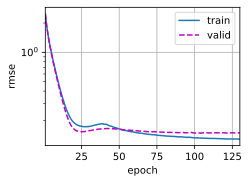

In [63]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 10, 130, 8, 0, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse:{float(train_l):f},'
      f'平均验证log rmse:{float(valid_l):f}')

训练log rmse:0.127160


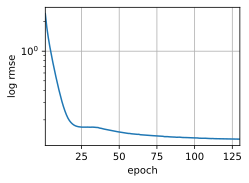

In [65]:
#提交kaggle预测
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
  net = get_net()
  train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
  d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
  print(f'训练log rmse:{float(train_ls[-1]):f}')
  # 将网络应用于测试集
  preds = net(test_features).detach().numpy()
  # 将其重新格式化以导入kaggle
  test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
  submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)